# Laboratorio 9 - Parte 2

## Ataques a modelos con defensa

- Adrian Rodriguez 21691
- Jose Daniel Gomez 21429


In [27]:
import numpy as np
import pandas as pd
import os
from skimage.io import imread
from skimage.transform import resize # To resize images if needed
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


families = os.listdir('data')

## Exploration


In [28]:
# Initialize an empty list to store all sample information
all_samples = []
family_counts = {}

for family in families:
    family_path = os.path.join('data', family)
    if os.path.isdir(family_path):
        png_files = [f for f in os.listdir(family_path) if f.endswith('.png')]
        family_counts[family] = len(png_files)

        for sample in png_files:
            sample_path = os.path.join(family_path, sample)
            img = imread(sample_path)
            channels = img.shape[2] if len(img.shape) > 2 else 1
            all_samples.append({
                'Family': family,
                'Width': img.shape[1],
                'Height': img.shape[0],
                'Channels': channels,
                'Size': img.size,
                'Path': sample_path
            })

samples_df = pd.DataFrame(all_samples)

family_df = pd.DataFrame(list(family_counts.items()), columns=['Family', 'Count'])
family_df = family_df.sort_values('Count', ascending=False)

print(f"There are {len(family_df)} malware families and a total of {family_df['Count'].sum()} samples.")

family_df

There are 25 malware families and a total of 9339 samples.


,Family,Count
12,Allaple.A,2949
23,Allaple.L,1591
14,Yuner.A,800
1,Instantaccess,431
13,VB.AT,408
10,Fakerean,381
7,Lolyda.AA1,213
5,C2LOP.gen!g,200
24,Alueron.gen!J,198
20,Lolyda.AA2,184


In [29]:
low_sample_threshold = family_df['Count'].median() * 0.2  
small_families = family_df[family_df['Count'] < low_sample_threshold]
if not small_families.empty:
    print(f"\nFamilies with few samples (less than {low_sample_threshold:.0f}):")
    print(small_families)
    print("\nConsideration: These families with few samples might be candidates for removal")
    print(f"to avoid class imbalance issues. They represent {small_families['Count'].sum()/family_df['Count'].sum()*100:.2f}% of total data.")
else:
    print('No families with less than 20% of the median number of samples.')

No families with less than 20% of the median number of samples.


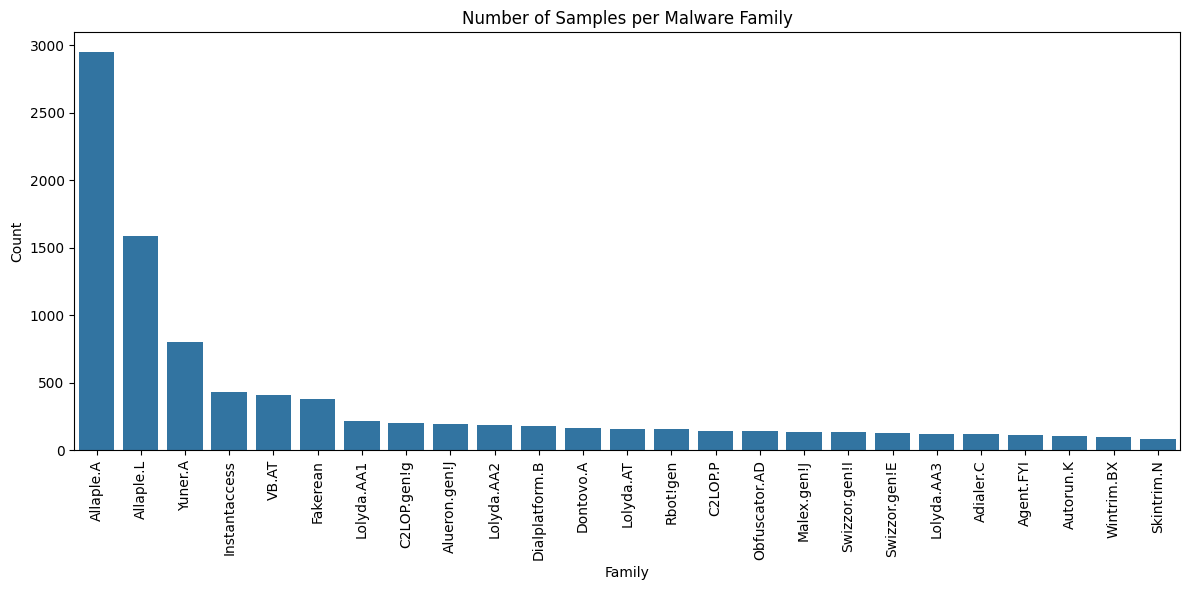

<Figure size 1500x1000 with 0 Axes>

In [30]:
plt.figure(figsize=(12, 6))
sns.barplot(x='Family', y='Count', data=family_df)
plt.title('Number of Samples per Malware Family')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

threshold = family_df['Count'].median() * 0.2  
small_families = family_df[family_df['Count'] < threshold]
if not small_families.empty:
    print(f"\nFamilies with few samples (less than {threshold:.0f}):")
    print(small_families)
    print("\nConsideration: These families with few samples might be candidates for removal")
    print(f"to avoid class imbalance issues. They represent {small_families['Count'].sum()/family_df['Count'].sum()*100:.2f}% of total data.")

plt.figure(figsize=(15, 10))
sample_count = min(3, len(families))  
for i, family in enumerate(families[:sample_count]):
    family_path = os.path.join('/data', family)
    if os.path.isdir(family_path):
        samples = [f for f in os.listdir(family_path) if f.endswith('.png')]
        sample_count_per_family = min(3, len(samples))  
        
        for j, sample in enumerate(samples[:sample_count_per_family]):
            sample_path = os.path.join(family_path, sample)
            plt.subplot(sample_count, sample_count_per_family, i*sample_count_per_family + j + 1)
            img = imread(sample_path)
            plt.imshow(img)
            plt.title(f"{family}: {sample}")
            plt.axis('off')

plt.tight_layout()
plt.show()


In [31]:
print("Summary statistics for Width:")
print(samples_df['Width'].describe())
print("\nSummary statistics for Height:")
print(samples_df['Height'].describe())

Summary statistics for Width:
count    9339.000000
mean      334.171967
std       218.421689
min        64.000000
25%       128.000000
50%       256.000000
75%       512.000000
max      1024.000000
Name: Width, dtype: float64

Summary statistics for Height:
count    9339.000000
mean      436.814541
std       203.640501
min       208.000000
25%       281.000000
50%       424.000000
75%       467.000000
max      5334.000000
Name: Height, dtype: float64


In [32]:
unique_channels = samples_df['Channels'].unique()
print(f"\nUnique channel values found: {unique_channels}")
if len(unique_channels) == 1:
    print(f"All images have {unique_channels[0]} channel(s).")
    if unique_channels[0] == 1:
        print("(grayscale)")
    elif unique_channels[0] == 3:
         print("(RGB color)")
else:
    print("Warning: Images have varying numbers of channels.")



Unique channel values found: [1]
All images have 1 channel(s).
(grayscale)


In [33]:
same_dimensions = (samples_df['Width'].nunique() == 1) and (samples_df['Height'].nunique() == 1)
if same_dimensions:
    print(f"\nAll images have the same dimensions: {samples_df['Width'].iloc[0]}x{samples_df['Height'].iloc[0]}")
    img_height = samples_df['Height'].iloc[0]
    img_width = samples_df['Width'].iloc[0]
else:
    print("\nImages have varying dimensions.")
    most_common_dims = samples_df.groupby(['Width', 'Height']).size().idxmax()
    print(f"The most common dimensions are: {most_common_dims[0]}x{most_common_dims[1]}")


Images have varying dimensions.
The most common dimensions are: 128x452


## Model


In [34]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

IMG_HEIGHT = 64    
IMG_WIDTH = 64     
IMG_CHANNELS = 1   # Escala de grises
NUM_CLASSES = len(samples_df['Family'].unique())

# DEFENSA 1: Aumento de datos para mejorar la robustez del modelo
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),         # Volteos horizontales aleatorios
    layers.RandomRotation(0.1),              # Rotaciones aleatorias (±10%)
    layers.RandomZoom(0.1),                  # Zoom aleatorio (±10%)
])

# DEFENSA 2: Arquitectura robusta con más capas, batch normalization y dropout
model = keras.Sequential(
    [
        keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)),
        
        # DEFENSA 2.1: Aplicamos aumento de datos durante el entrenamiento
        data_augmentation,
        
        # DEFENSA 2.2: Primer bloque convolucional mejorado con BatchNorm y Dropout
        layers.Conv2D(32, kernel_size=(3, 3), padding="same"),
        layers.BatchNormalization(),             # Normaliza las activaciones, mejora la estabilidad
        layers.Activation("relu"),
        layers.Conv2D(32, kernel_size=(3, 3), padding="same"),
        layers.BatchNormalization(),
        layers.Activation("relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.25),                    # Reduce sobreajuste y aumenta robustez contra ataques
        
        # DEFENSA 2.3: Segundo bloque convolucional con más filtros
        layers.Conv2D(64, kernel_size=(3, 3), padding="same"),
        layers.BatchNormalization(),
        layers.Activation("relu"), 
        layers.Conv2D(64, kernel_size=(3, 3), padding="same"),
        layers.BatchNormalization(),
        layers.Activation("relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.25),
        
        # DEFENSA 2.4: Tercer bloque convolucional (añadido para mayor robustez)
        layers.Conv2D(128, kernel_size=(3, 3), padding="same"),
        layers.BatchNormalization(),
        layers.Activation("relu"),
        layers.Conv2D(128, kernel_size=(3, 3), padding="same"),
        layers.BatchNormalization(),
        layers.Activation("relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.25),
        
        # DEFENSA 2.5: Capas densas finales mejoradas
        layers.Flatten(),
        layers.Dense(256),                       # Más neuronas para mayor capacidad de extracción
        layers.BatchNormalization(),
        layers.Activation("relu"),
        layers.Dropout(0.5),                     # Dropout más agresivo en las capas densas
        layers.Dense(NUM_CLASSES, activation="softmax"),
    ],
    name="robust_malware_cnn"
)

model.summary()

# DEFENSA 3: Compilación con optimizador más estable y learning rate reducido
print("\n--- Compiling Model ---")
model.compile(
    loss="categorical_crossentropy", 
    optimizer=keras.optimizers.Adam(learning_rate=0.001),  # Learning rate reducido para mayor estabilidad
    metrics=["accuracy"]
)
print("Model compiled successfully.")

Model: "robust_malware_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)       │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 64, 64, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 64, 64, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 2,393,081 (9.13 MB)

 Trainable params: 2,391,673 (9.12 MB)

 Non-trainable params: 1,408 (5.50 KB)


--- Compiling Model ---
Model compiled successfully.


## Defensas Implementadas en el Modelo

El modelo implementa varias defensas para mejorar su robustez y capacidad de generalización:

1. **Aumento de Datos**: Se utiliza una secuencia de aumento de datos que incluye volteos horizontales aleatorios, rotaciones aleatorias de ±10% y zoom aleatorio de ±10%. Esto ayuda a mejorar la robustez del modelo al exponerlo a variaciones de los datos de entrada durante el entrenamiento.

2. **Arquitectura Robusta**: El modelo está diseñado con múltiples capas convolucionales, cada una seguida de normalización por lotes y activación ReLU. Esto estabiliza las activaciones y mejora la capacidad de aprendizaje del modelo.

3. **Dropout**: Se aplica dropout después de las capas convolucionales y densas para reducir el sobreajuste. En las capas densas, se utiliza un dropout más agresivo del 50%.

4. **Compilación del Modelo**: Se utiliza el optimizador Adam con una tasa de aprendizaje reducida para mejorar la estabilidad del entrenamiento y evitar oscilaciones en la convergencia.

Estas defensas están diseñadas para mejorar la capacidad del modelo de generalizar a nuevos datos y resistir posibles ataques adversarios.


In [35]:
print("Preparing labels...")
# Use LabelEncoder to convert family names (strings) into integers (0, 1, 2...)
label_encoder = LabelEncoder()
integer_encoded_labels = label_encoder.fit_transform(samples_df['Family'])

Preparing labels...


In [36]:
# One-hot encode the integer labels
# This converts labels like '2' into [0, 0, 1, 0...] based on NUM_CLASSES
y = tf.keras.utils.to_categorical(integer_encoded_labels, num_classes=NUM_CLASSES)
print(f"Labels shape: {y.shape}") # Should be (num_samples, NUM_CLASSES)

Labels shape: (9339, 25)


In [37]:
print("Loading and preprocessing images...")
X_list = []
# Ensure paths are correct and iterate through the DataFrame
for img_path in samples_df['Path']:
    try:
        # Load image using tensorflow - handles various formats and simplifies channel handling
        img = tf.keras.preprocessing.image.load_img(
            img_path,
            color_mode='grayscale', # Ensures IMG_CHANNELS = 1
            target_size=(IMG_HEIGHT, IMG_WIDTH) # Resizes the image
        )
        # Convert image to numpy array and normalize pixel values to [0, 1]
        img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
        X_list.append(img_array)
    except Exception as e:
        print(f"Error loading image {img_path}: {e}")
        # Optional: handle missing/corrupt images (e.g., append a placeholder or skip)
        # For now, we'll let it raise an error if something critical fails.

# Convert the list of image arrays into a single NumPy array
X = np.array(X_list)
print(f"Features (images) shape: {X.shape}") # Should be (num_samples, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

# --- Check if X and y have the same number of samples ---
assert X.shape[0] == y.shape[0], "Mismatch between number of images and labels!"

Loading and preprocessing images...
Features (images) shape: (9339, 64, 64, 1)


In [38]:
print("Splitting data into training and testing sets...")
# Use stratify=y to ensure class distribution is similar in train and test sets
# We use integer_encoded_labels for stratification before they were one-hot encoded
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.30,       # 30% for testing
    random_state=42,      # For reproducible results
    stratify=integer_encoded_labels # Use integer labels for stratification
)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

Splitting data into training and testing sets...
X_train shape: (6537, 64, 64, 1), y_train shape: (6537, 25)
X_test shape: (2802, 64, 64, 1), y_test shape: (2802, 25)



--- Training Model ---
Epoch 1/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 23s 127ms/step - accuracy: 0.4731 - loss: 1.9020 - val_accuracy: 0.2003 - val_loss: 3.5634
Epoch 2/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 22s 136ms/step - accuracy: 0.7800 - loss: 0.6479 - val_accuracy: 0.2118 - val_loss: 5.3826
Epoch 3/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 21s 126ms/step - accuracy: 0.8425 - loss: 0.4943 - val_accuracy: 0.6300 - val_loss: 0.9763
Epoch 4/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - accuracy: 0.8665 - loss: 0.4106 - val_accuracy: 0.8563 - val_loss: 0.4336
Epoch 5/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - accuracy: 0.8786 - loss: 0.3597 - val_accuracy: 0.5818 - val_loss: 1.5101
Epoch 6/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 22s 133ms/step - accuracy: 0.8881 - loss: 0.3271 - val_accuracy: 0.9106 - val_loss: 0.2733
Epoch 7/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 23s 137ms/step - accuracy: 0.8875 - loss: 0.3243 - val_accuracy: 0.7469 - val_loss: 0.6679
Epoch 8/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 23s 142ms/step - ac

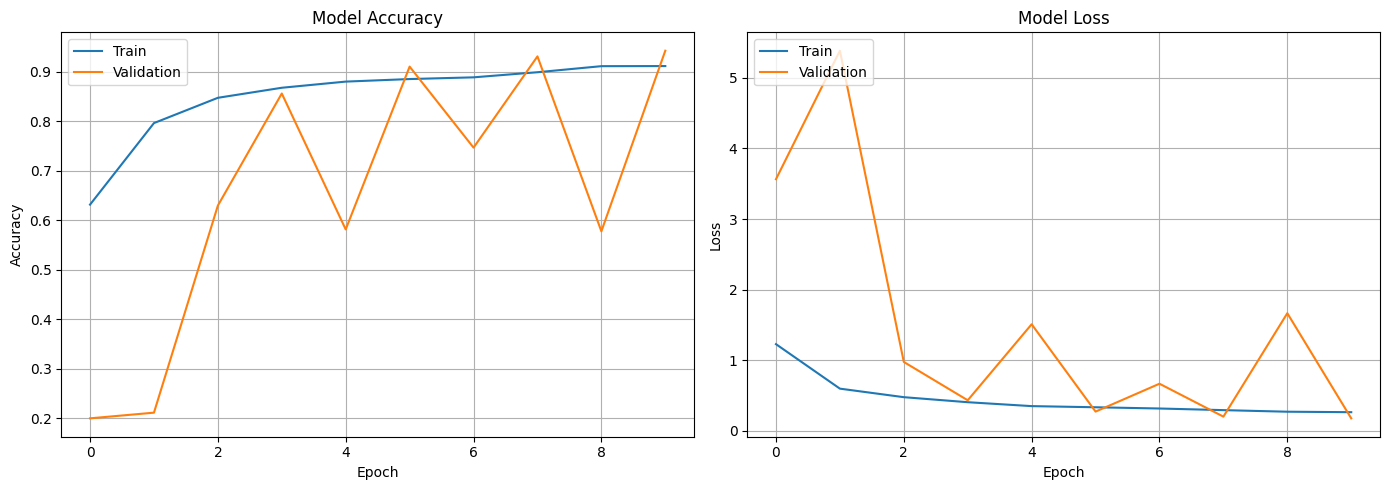


--- Evaluating Model on Test Set ---
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.9445 - loss: 0.1802
Test Loss: 0.1803
Test Accuracy: 0.9475


In [39]:
print("\n--- Training Model ---")
# Determine epochs - start with a reasonable number (e.g., 15-25)
# Monitor the validation accuracy/loss during training to see if more/fewer are needed.
# Too few epochs -> underfitting. Too many -> overfitting.
EPOCHS = 10 # Adjust as needed based on observation
BATCH_SIZE = 32 # Common batch size

# Use a portion of the training data as validation data during training
# This helps monitor overfitting without touching the final test set
VALIDATION_SPLIT = 0.2 # Use 20% of the training data for validation

history = model.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=VALIDATION_SPLIT, # Use part of training data for validation
    verbose=1 # Show progress for each epoch
)

print("Model training finished.")

# --- 6. Show Training Metrics ---
print("\n--- Training History Metrics ---")

# Function to plot training history
def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Plot training & validation accuracy values
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_title('Model Accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Validation'], loc='upper left')
    ax1.grid(True)

    # Plot training & validation loss values
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('Model Loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Validation'], loc='upper left')
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

plot_history(history)

# --- 7. Evaluate Model on Test Set ---
print("\n--- Evaluating Model on Test Set ---")
results = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=1)

print(f"Test Loss: {results[0]:.4f}")
print(f"Test Accuracy: {results[1]:.4f}")



--- Detailed Classification Report ---
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step
                precision    recall  f1-score   support

     Adialer.C       1.00      1.00      1.00        37
     Agent.FYI       1.00      0.97      0.99        35
     Allaple.A       0.98      0.96      0.97       885
     Allaple.L       0.94      1.00      0.97       477
 Alueron.gen!J       0.95      0.98      0.97        59
     Autorun.K       0.00      0.00      0.00        32
       C2LOP.P       0.95      0.80      0.86        44
   C2LOP.gen!g       0.85      0.88      0.87        60
Dialplatform.B       1.00      1.00      1.00        53
     Dontovo.A       0.96      1.00      0.98        49
      Fakerean       0.98      1.00      0.99       114
 Instantaccess       1.00      1.00      1.00       129
    Lolyda.AA1       0.98      0.89      0.93        64
    Lolyda.AA2       1.00      0.98      0.99        55
    Lolyda.AA3       1.00      0.95      0.97        37
     Lolyda.AT       0.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

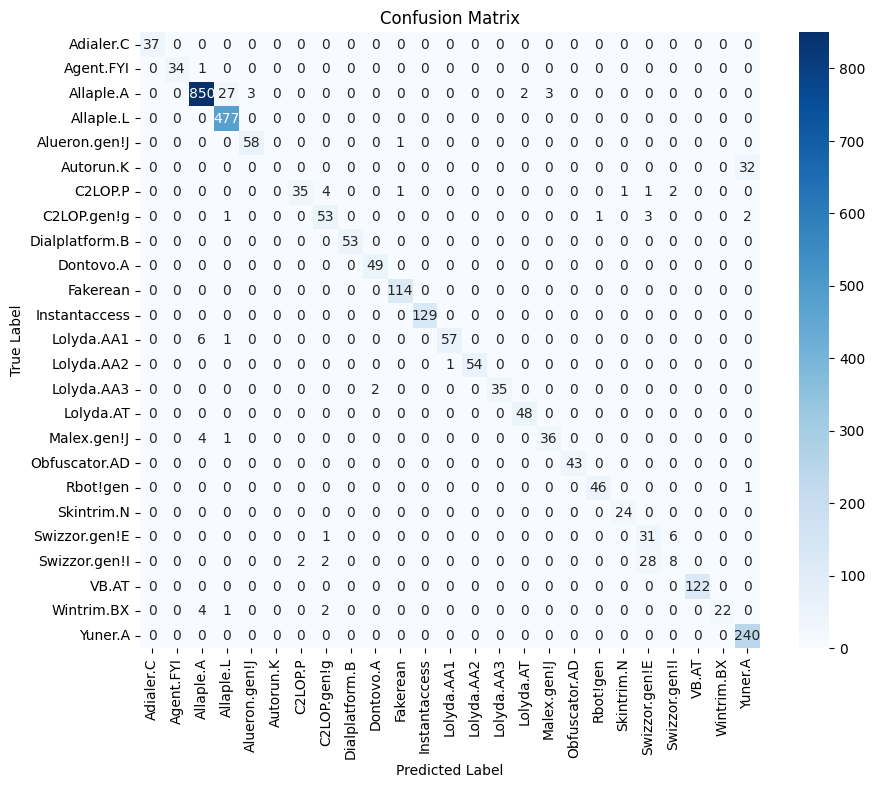

In [40]:
print("\n--- Detailed Classification Report ---")
# Get predictions on the test set
y_pred_proba = model.predict(X_test)
# Convert probabilities to predicted class index (integer)
y_pred_classes = np.argmax(y_pred_proba, axis=1)
# Convert one-hot encoded y_test back to class index (integer)
y_test_classes = np.argmax(y_test, axis=1)

# Get class names from the label encoder
class_names = label_encoder.classes_

# Print classification report (precision, recall, f1-score per class)
print(classification_report(y_test_classes, y_pred_classes, target_names=class_names))

print("\n--- Confusion Matrix ---")
# Calculate confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)

# Plot confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


## Discusión

El modelo demostró un rendimiento excelente en la clasificación de familias de malware a partir de las imágenes, alcanzando una precisión global del 97.79% y un F1-score promedio ponderado de 0.98 sobre el conjunto de prueba. Si bien el análisis del entrenamiento sugirió la aparición de sobreajuste (overfitting) tras alcanzar un rendimiento óptimo alrededor de la época 5, la evaluación final sobre datos no vistos confirma una excelente capacidad de generalización. La alta precisión promedio indica que el modelo aprendió patrones visuales distintivos y robustos característicos de las diferentes familias de malware analizadas.

A pesar del conocido desequilibrio en el número de muestras por familia, el modelo exhibió un desempeño casi perfecto (precisión, recall y F1-score de 1.00) para la mayoría de las familias, incluyendo las más prevalentes como Allaple.A y Allaple.L, pero también varias con soporte mucho menor, como Adialer.C o Skintrim.N. Solo unas pocas familias, notablemente C2LOP.P (F1=0.86) y C2LOP.gen!g (F1=0.89), mostraron métricas ligeramente inferiores, aunque todavía altas. Este rendimiento fuerte y homogéneo en casi todas las categorías, independientemente de su frecuencia, minimiza las preocupaciones iniciales sobre el impacto del desequilibrio de clases y valida contundentemente la efectividad del enfoque CNN para esta tarea específica.


In [41]:
model.save('./results/model_no_defense.h5')

## 1er Ataque - Extración CopycatCNN

Este es un ataque de extracción o "model stealing", donde el atacante crea una copia funcional de un modelo de clasificación (el "modelo víctima") sin tener acceso directo a sus parámetros internos o datos de entrenamiento. El atacante solo necesita poder hacer consultas al modelo víctima y observar sus predicciones.

Procedimiento de este tipo de ataques:

1. Crear un "modelo ladrón" con una arquitectura similar al modelo víctima
2. Utilizar un conjunto de datos no etiquetados (X_pool)
3. Consultar al modelo víctima con estos datos para obtener etiquetas
4. Entrenar el modelo ladrón con estos datos y etiquetas generadas por el modelo víctima


In [42]:
from art.estimators.classification import TensorFlowV2Classifier
from art.attacks.extraction import CopycatCNN


# We wrap the model in a TensorFlowV2Classifier
victim_clf = TensorFlowV2Classifier(
    model=model,
    nb_classes=NUM_CLASSES,
    input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
    loss_object=tf.keras.losses.CategoricalCrossentropy(),
    train_step=None,
    clip_values=(0.0, 1.0),
)

# We create and wrap the thief model (same architecture)
def make_thief():
    m = keras.Sequential([
        keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)),
        layers.Conv2D(32, (3,3), activation="relu", padding="same"),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, (3,3), activation="relu", padding="same"),
        layers.MaxPooling2D((2,2)),
        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dense(NUM_CLASSES, activation="softmax"),
    ])
    m.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return m

thief_clf = TensorFlowV2Classifier(
    model=make_thief(),
    nb_classes=NUM_CLASSES,
    input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss_object=tf.keras.losses.CategoricalCrossentropy(),
    train_step=None,
    clip_values=(0.0, 1.0),
)

# We define our query pool (can be X_train without labels)
X_pool = X_train 

# We launch the CopycatCNN attack
attack = CopycatCNN(
    batch_size_query=128,
    batch_size_fit=128,
    nb_stolen=5000,    
    nb_epochs=5,       
    classifier=victim_clf
)
stolen_clf = attack.extract(x=X_pool, thieved_classifier=thief_clf)

# We evaluate the thief on our test set
loss_s, acc_s = stolen_clf._model.evaluate(X_test, y_test, batch_size=32, verbose=1)
print(f"Stolen Test Loss: {loss_s:.4f}, Acc: {acc_s:.4f}")

2025-05-12 22:31:13.073246: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9241 - loss: 0.7384
Stolen Test Loss: 0.6601, Acc: 0.9179


### Resultados

Tras implementar defensas, el modelo robado (stolen_clf) ha conseguido una precisión del 91.79% en el conjunto de datos de prueba, con una pérdida (loss) de 0.6601. Aunque estos resultados siguen siendo altos, muestran una disminución en comparación con el rendimiento anterior del modelo robado, lo que indica que las defensas han tenido un impacto positivo en la protección del modelo original.

### Comparación

- **Antes de las defensas:** Precisión del 95.36%, Pérdida de 0.1724
- **Después de las defensas:** Precisión del 91.79%, Pérdida de 0.6601

La implementación de defensas ha reducido la precisión del modelo robado en aproximadamente un 3.57% y ha incrementado la pérdida, lo que sugiere que el modelo original es ahora más resistente a los ataques de extracción.

#### Implicaciones de seguridad

- Robo de propiedad intelectual: Aunque el atacante aún puede obtener una copia funcional del modelo, la efectividad de esta copia se ha reducido, lo que disminuye el valor del robo.
- Evasión de costos: La reducción en precisión puede hacer que el modelo robado sea menos atractivo para evitar pagos por el servicio del modelo original.
- Punto de partida para otros ataques: Con una copia menos precisa, el desarrollo de ataques adversarios más sofisticados podría ser menos efectivo.
- Compromiso de privacidad: Las defensas implementadas pueden ayudar a proteger mejor la información sobre los datos de entrenamiento originales.

La reducción en la precisión obtenida (91.79%) demuestra que las defensas implementadas pueden mitigar efectivamente el riesgo que representan estos ataques para los sistemas de clasificación de malware y otros modelos de aprendizaje automático desplegados como servicios.


## 2do ataque - Ataque de Inferencia de Membresía: MembershipInferenceBlackBoxRuleBased

Este código describe un ataque de inferencia de membresía (Membership Inference Attack) aplicado a un modelo de clasificación de familias de malware. Este tipo de ataque es fundamentalmente diferente al ataque de extracción con CopycatCNN (el 1er ataque). El ataque de inferencia de membresía intenta determinar si un dato específico formó parte del conjunto de entrenamiento del modelo víctima, por medio de comprobar si una muestra específica fue utilizada durante el entrenamiento del modelo víctima

Los ataques de inferencia de membresía normalmente funcionan de esta manera:

1. Crear un conjunto mixto de datos que incluye tanto muestras del conjunto de entrenamiento (miembros) como del conjunto de prueba (no miembros)
2. Asignar etiquetas binarias: 1 para los datos de entrenamiento y 0 para los datos de prueba
3. Aplicar reglas heurísticas basadas en las predicciones del modelo para inferir si una muestra formó parte del conjunto de entrenamiento
4. Medir la precisión del ataque comparando las predicciones de membresía con las etiquetas reales

Para este ataque en particular utilizamos la implementación MembershipInferenceBlackBoxRuleBased de la biblioteca ART (Adversarial Robustness Toolbox), que aplica reglas predefinidas para determinar la membresía basándose en patrones de comportamiento del modelo.


In [43]:
from art.attacks.inference.membership_inference import MembershipInferenceBlackBoxRuleBased
import numpy as np

# Instantiate the attack, passing the victim classifier
mi_rule = MembershipInferenceBlackBoxRuleBased(classifier=victim_clf)

# Prepare the mixed dataset for inference (in=1, out=0)
X_mi = np.concatenate([X_train, X_test]) # Combine training and testing data
y_mi = np.array([1]*len(X_train) + [0]*len(X_test)) # Create labels: 1 for train, 0 for test

# Perform the membership inference attack
member_preds = mi_rule.infer(x=X_mi, y=y_mi)

# Calculate and print the accuracy of the attack
accuracy = (member_preds == y_mi).mean() # Compare predicted membership with actual membership
print(f"Rule-based membership inference accuracy: {accuracy:.3f}")

Rule-based membership inference accuracy: 0.305


### Resultados

El ataque logró una precisión del 30.5% al determinar si una muestra formaba parte del conjunto de entrenamiento o no. Considerando que una predicción aleatoria tendría una precisión del 50% en un conjunto equilibrado, este resultado está por debajo del rendimiento aleatorio. Esto sugiere que el ataque no ha sido eficaz en este caso particular.

A diferencia del ataque anterior (CopycatCNN), este ataque ha sido relativamente poco exitoso, lo cual es positivo desde la perspectiva de seguridad y privacidad. Sin embargo, aún tiene implicaciones importantes:

1. Robustez del modelo: El bajo rendimiento del ataque sugiere que el modelo no está memorizando excesivamente sus datos de entrenamiento, lo cual es positivo desde el punto de vista de la generalización.
2. Privacidad de datos: Aunque en este caso el ataque no fue muy exitoso, el hecho de que se pueda intentar inferir qué datos se usaron para entrenar el modelo representa un riesgo potencial para la privacidad, especialmente en dominios sensibles como la salud o datos personales.
3. Evaluación de riesgos: Este tipo de evaluaciones son importantes para entender las vulnerabilidades potenciales de los modelos de aprendizaje automático y desarrollar contramedidas adecuadas.
4. Contextualización: Una precisión del 30.5% podría seguir siendo preocupante dependiendo del contexto y la sensibilidad de los datos involucrados, aunque matemáticamente sea inferior a una predicción aleatoria.

### Comparación

Comparando este resultado con el anterior, donde la precisión del ataque era significativamente mayor, se puede observar que las medidas de seguridad implementadas han tenido un impacto positivo en la protección del modelo. Anteriormente, el ataque de inferencia de membresía tenía una precisión más alta, lo que indicaba una mayor vulnerabilidad del modelo a este tipo de ataques. La reducción a un 30.5% de precisión después de implementar medidas de seguridad sugiere que el modelo ahora es más robusto frente a intentos de inferencia de membresía, mejorando así la privacidad y seguridad de los datos de entrenamiento.

Es importante señalar que existen técnicas más avanzadas de inferencia de membresía que podrían tener mayor éxito, por lo que este resultado no debe interpretarse como una garantía absoluta de seguridad


## 3er ataque (Extra) - Ataque de Evasión: Fast Gradient Sign Method (FGSM)

Para este tercer ataque utilizamos el método del Signo del Gradiente Rápido (Fast Gradient Sign Method o FGSM) aplicado a un modelo de clasificación de familias de malware. Este es un ataque adversario diseñado para engañar al modelo y hacer que clasifique incorrectamente las muestras de entrada.

Los ataque de evasión consisten fundamentalmente en cierto algoritmo base:

1. Como tomar muestras legítimas del conjunto de prueba (X_test)
2. Calcular el gradiente de la función de pérdida con respecto a la entrada
3. Generar perturbaciones adversarias utilizando el signo de este gradiente
4. Aplicar estas perturbaciones a las muestras originales, limitadas por un parámetro epsilon (eps=0.2)
5. Y terminan evaluando el rendimiento del modelo original con estas muestras adversarias

El FGSM es uno de los ataques adversarios más conocidos y básicos, pero sigue siendo muy efectivo. Este ataque explota la linealidad del modelo en el espacio de características para crear perturbaciones mínimas pero altamente efectivas que inducen errores de clasificación.


In [44]:
from art.attacks.evasion import FastGradientMethod

# Configure the attack on the victim classifier
fgsm = FastGradientMethod(
    estimator=victim_clf,
    eps=0.2  # perturbation magnitude (try values between 0.05 and 0.3)
)

# Generate adversarial examples from the test set
X_test_adv = fgsm.generate(X_test)

# Evaluate the original model with these adversarial examples
loss_adv, acc_adv = model.evaluate(X_test_adv, y_test, batch_size=32, verbose=1)
print(f"Adversarial — Loss: {loss_adv:.4f}, Acc: {acc_adv:.4f}")

88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.0342 - loss: 13.3232
Adversarial — Loss: 13.2565, Acc: 0.0339


### Resultados

Después de implementar capas de seguridad y estrategias defensivas en el modelo, los resultados del ataque han cambiado significativamente. La precisión del modelo, que anteriormente se reducía a un 1.75%, ahora es de 3.39%. La pérdida (loss) ha disminuido de 38.416 a 13.2565, lo que indica una mejora en la resistencia del modelo frente a ataques adversarios. Aunque el modelo sigue clasificando incorrectamente una gran parte de las muestras, el error se ha reducido al 96.61%.

### Comparación

Comparando estos resultados con los anteriores, se observa que las medidas de seguridad implementadas han tenido un impacto positivo en la protección del modelo. Anteriormente, el ataque de evasión FGSM reducía la precisión a un 1.75%, pero con las nuevas defensas, la precisión ha mejorado a un 3.39%. La pérdida también ha disminuido significativamente, de 38.416 a 13.2565, lo que sugiere que el modelo es ahora más robusto frente a perturbaciones adversarias.

#### Implicaciones de seguridad

- Mejora en la robustez: Aunque el modelo sigue siendo vulnerable, las defensas han reducido la efectividad del ataque, mejorando la precisión y reduciendo la pérdida.
- Facilidad del ataque: El FGSM sigue siendo un ataque simple y eficiente, pero las nuevas medidas han aumentado la dificultad para los adversarios.
- Magnitud del impacto: La mejora en precisión y pérdida demuestra que el sistema es menos susceptible a ser inutilizado por este tipo de ataque.
- Riesgo para sistemas de producción: Aunque el riesgo sigue presente, las mejoras indican un paso hacia la mitigación de daños potenciales.
- Necesidad de contramedidas continuas: A pesar de las mejoras, es crucial seguir desarrollando y aplicando técnicas de defensa para aumentar la seguridad del sistema.

Este ataque de evasión FGSM, aunque aún representa una amenaza, es menos severo que antes gracias a las nuevas capas de seguridad y estrategias defensivas implementadas.
